# Sea ice thickness in simulations with a dynamic ocean model versus a slab ocean model


### Science goals
- Examine differences in annual and monthly Arctic and Antarctic sea ice thickness in B and E compset simulations with constant forcing <br>
- Hypothesize reasons for different ice thickness in B and E compset cases <br>
- Examine patterns of thickness variability via EOF analysis <br>
- Identify ice thickness seasonal cycle evolution versus interannual/longer frequency variability <br>

### Technical goals
- Learn how to examine a whole netCDF as an xarray DataSet object <br>
- Make minor changes to simple Python plotting routines <br>
- Gain familiarity with implementing EOF analysis through the scikit-learn package<br>


### Loading in packages, model output, and simple xarray manipulations

In [1]:
#loading packages
import xarray as xr                       #package for netCDF reading and slick netCDF manipulation
import numpy as np                        #standard package for handling numbers and calculations
import matplotlib.pyplot as plt           #standard package for plotting 
import glob                               #for Unix-style pathname pattern expansion, https://en.wikipedia.org/wiki/Glob_(programming)
from matplotlib.gridspec import GridSpec  #for multipanel plots
from sklearn.decomposition import PCA     #EOF implementation from the scikit-learn package

%matplotlib inline                        
#"magic" to make figures show up after each cell

In this activity, we will be examining ice thickness in two simulations that both have constant 1850-level forcing. One simulation is the fully-coupled CESM (B-compset) and the other has a slab ocean model coupled to prognostic atmos+land+sea ice (E-compset). 

In the following cell we will decide if we want to look at Arctic or Antarctic sea ice thickness (set yes_arctic OR yes_antarctic to 1). If there's time before lunch, you can always go back and examine the other pole's sea ice thickness.

In [2]:
#Let's examine ice thickness in B and E cases

#directory for sea ice thickness from Large Ensemble on glade
lens_dir='/glade/p_old/cesmLE/CESM-CAM5-BGC-LE/ice/proc/tseries/monthly/hi/'

#SELECT HERE if you want to do Arctic or Antarctic sea ice thickness first. 1=yes, 0=no
yes_arctic=0
yes_antarctic=1

#create list of files for b-case, e-case a la "glob": https://en.wikipedia.org/wiki/Glob_(programming)
if yes_arctic==1:
    bfiles=sorted(glob.glob(lens_dir+'b.e11.B1850C5CN.f09_g16.005.cice.h.hi_nh.*.nc'))
    efiles=sorted(glob.glob(lens_dir+'e.e11.E1850C5CN.f09_g16.001.cice.h.hi_nh.*.nc'))
elif yes_antarctic==1:
    bfiles=sorted(glob.glob(lens_dir+'b.e11.B1850C5CN.f09_g16.005.cice.h.hi_sh.*.nc'))
    efiles=sorted(glob.glob(lens_dir+'e.e11.E1850C5CN.f09_g16.001.cice.h.hi_sh.*.nc'))
    
#a little Python aside: Python loops and if-statements do not have "end" statements.
#Python tells what's in the loop/not through what's indented. 

We are going to open 200 years of B and E compset sea ice output to analyze.  There are more years, but to read more output into memory would take more time, and really 200 years is fine for our needs.

In [3]:
#open up the files - only loading 2 files (200 years) to save memory

ds_b=xr.open_mfdataset(bfiles[0:2],decode_times=False)  #only opening 200 years worth b/c memory
print('opened b')
ds_e=xr.open_mfdataset(efiles[0:2],decode_times=False)  #only opening 200 years worth b/c memory
print('opened e')

opened b
opened e


In the previous module, we opened pre-processed output in the "pickle" format. These pickles each contained an xarray object called a "DataArray."  DataArrays are the representation of a single array - they include one variable (SST or ice thickness or whatever) and its associated coordinates and attributes.

This time, we are opening up a netCDF directly using xarray (in the above cell). To create a representation of a full netCDF, xarray reads the netCDF into an object called a "DataSet."  DataSets contain everything that is in the original netCDF (all the variables, dimensions, coordinates, metadata, attributes).

In the following few cells, we will practice examining one of the DataSets that we just created. 

*(A side note: xarray can open DataSets from netCDF4, netCDF3, HDF, files on openDAP/thredds servers, GRIB, zarr, and other file formats, and also has functionality for multi-processor processing through another package called dask)* 

In [4]:
#First, we are going to print out the entire DataSet.  
#This is analogous to "ncdump -h name_of_file.nc" on the command line
print(ds_b)

<xarray.Dataset>
Dimensions:      (d2: 2, ni: 320, nj: 76, nvertices: 4, time: 2400)
Coordinates:
    TLAT         (time, nj, ni) float32 -79.22052 -79.22052 -79.22052 ...
    TLON         (time, nj, ni) float32 320.5625 321.6875 322.8125 323.9375 ...
    ULAT         (time, nj, ni) float32 -78.952896 -78.952896 -78.952896 ...
    ULON         (time, nj, ni) float32 321.125 322.25 323.375 324.5 325.625 ...
  * time         (time) float64 1.46e+05 1.461e+05 1.461e+05 1.461e+05 ...
Dimensions without coordinates: d2, ni, nj, nvertices
Data variables:
    ANGLE        (time, nj, ni) float32 dask.array<shape=(2400, 76, 320), chunksize=(1200, 76, 320)>
    ANGLET       (time, nj, ni) float32 dask.array<shape=(2400, 76, 320), chunksize=(1200, 76, 320)>
    HTE          (time, nj, ni) float32 dask.array<shape=(2400, 76, 320), chunksize=(1200, 76, 320)>
    HTN          (time, nj, ni) float32 dask.array<shape=(2400, 76, 320), chunksize=(1200, 76, 320)>
    blkmask      (time, nj, ni) float32 d

In the above cell, identify the dimensions, coordinates and variables.  Now, you pick one of the variables (e.g., 'tarea','hi', 'blkmask'), and in the below cell, we will select just that variable and put it into its own object.

Selecting one variable from a DataSet creates a DataArray with just that variables and its associated dimensions.

In [5]:
#Pick one variable name

test_var=ds_b['uarea']  #fill in VARIABLE here with your choice of variable, 
#remember to put it in string format with single or double quotations around it, like this: 'hi' or "hi" 

print(test_var)

<xarray.DataArray 'uarea' (time: 2400, nj: 76, ni: 320)>
dask.array<shape=(2400, 76, 320), dtype=float32, chunksize=(1200, 76, 320)>
Coordinates:
    TLAT     (time, nj, ni) float32 -79.22052 -79.22052 -79.22052 -79.22052 ...
    TLON     (time, nj, ni) float32 320.5625 321.6875 322.8125 323.9375 ...
    ULAT     (time, nj, ni) float32 -78.952896 -78.952896 -78.952896 ...
    ULON     (time, nj, ni) float32 321.125 322.25 323.375 324.5 325.625 ...
  * time     (time) float64 1.46e+05 1.461e+05 1.461e+05 1.461e+05 1.462e+05 ...
Dimensions without coordinates: nj, ni
Attributes:
    long_name:  area of U grid cells
    units:      m^2


xarray can write out DataSets and DataArrays as netcdfs if needed (e.g. test_var.to_netcdf(filedir/filename.nc)).  We don't need to do that for this exercise, but this might be useful info for the future.

### Examining annual mean and monthly means of NH or SH ice thickness

In [6]:
#load variable into memory - this will take a minute

hi_b=ds_b['hi'].load()  

#this .load() method loads the data into memory, rather than just pointing to it and reading only metadata

#xarray does not read any portion of a netCDF into memory until it needs to. This is a desirable feature
#because it allows you to only read into memory what you need. When data becomes large, reading into memory 
#can become a time-consuming task. You can sub-select just the pieces you need and then only those pieces will be
#read in. 

#Normally xarray will handle the reading into memory when it finally needs to, and you don't need to call
#.load(). However, I've run into cases where xarray reads the same thing into memory multiple times, 
#which can be time-consuming when datasets are large, so I like to force it to read it in just the one time.
#Once the whole variable is in memory, then it won't read it in again. Will save you a little time later. -Liz.

#We want all of the ice thickness variable ('hi'), so to guarantee 
print('loaded b')
hi_e=ds_e['hi'].load()
print('loaded e')

loaded b
loaded e


First we will look at the difference in annual mean sea ice thickness in the B and E compset cases.

**Group discussion question:** discuss with your group and make a hypothesis about which case will have thicker annual mean sea ice.  

taken the time mean for B-compset
taken the time mean for E-compset


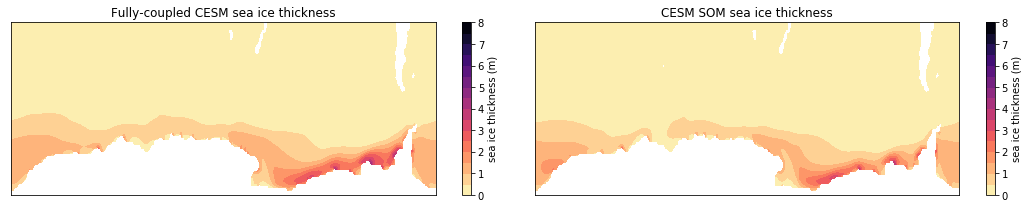

In [7]:
#annual mean sea ice thickness calculated here

#pull coordinates
nj=ds_b['nj']
ni=ds_b['ni']

time_b=ds_b['time']
time_e=ds_e['time']

#take mean to make climatology
hi_b_mean=hi_b.mean('time')  
#this is where a hint of xarray's slickness can be seen.  With numpy, you need to keep track which "axis" of the array
#represents the time or lat or lon. xarray takes care of that for you. You just need to know the name of the dimension.
print('taken the time mean for B-compset')
#I find it helpful to add print statements into your code so that you can see what part of the code is long

hi_e_mean=hi_e.mean('time')
print('taken the time mean for E-compset')  

#now let's plot the two climatologies
f=plt.figure(figsize=(15,3))  #define figure object and its size
gs=GridSpec(1,2)  # create a GridSpec object to make a figure with two panels in one row

#b-case on the left
plt.subplot(gs[0,0])  #define one subplot and where to put it in the GridSpec object "gs"
levels=np.arange(0,8.1,0.5)  #define edges for contours 
cs=plt.contourf(hi_b_mean,levels,cmap=plt.cm.magma_r)  #Magma is a matplotlib colormap
#check out other matplotlib colormaps here: https://matplotlib.org/examples/color/colormaps_reference.html
#feel free to try other colormaps. 
plt.xticks([],[]) #these two lines turn off the x-axis and y-axis ticks, which I find ugly in this context.
plt.yticks([],[]) #totally a stylistic choice on my part -Liz
cb=plt.colorbar(cs)  #adds colorbar
cb.set_label('sea ice thickness (m)')  #adds label for colorbar
plt.title('Fully-coupled CESM sea ice thickness');  #adds title to panel

#e-case on the right
plt.subplot(gs[0,1])
cs=plt.contourf(hi_e_mean,levels,cmap=plt.cm.magma_r)
plt.xticks([],[])
plt.yticks([],[])
cb=plt.colorbar(cs)
cb.set_label('sea ice thickness (m)')
plt.title('CESM SOM sea ice thickness');

plt.tight_layout()  #makes the panels scale together nicely

#Note that the sea ice is on the POP grid, which is not on a rectilinear grid, so there's distortion in the below
#figures. 

#A side note: If this weren't an exercise, we would correct this distortion and plot these on a formal map 
#using a package like "cartopy" or "Basemap."  
#PyNGL (based upon NCL) takes the POP grid and plots without distortion natively.

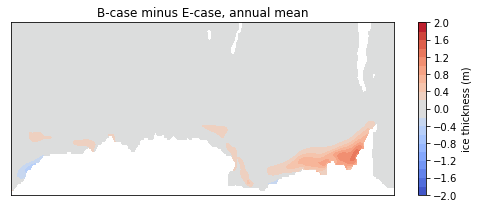

In [8]:
#Let's make a difference plot to see more clearly

f=plt.figure(figsize=(7,3))

maxlev=2  #set some params for contour edges
deltlev=maxlev/10
levels=np.concatenate((np.arange(-1*maxlev,0,deltlev),np.arange(deltlev,maxlev+deltlev/10,deltlev)))
#creates levels for contour map that center white at 0

cs=plt.contourf(hi_b_mean-hi_e_mean,levels,cmap=plt.cm.coolwarm)
plt.xticks([],[])
plt.yticks([],[])
cb=plt.colorbar(cs,spacing='proportional',ticks=np.arange(-1*maxlev,maxlev+deltlev,deltlev*2))
plt.title('B-case minus E-case, annual mean')
cb.set_label('ice thickness (m)')
    
plt.tight_layout()

#### Group discussion questions

Which simulation has greater sea ice thickness in the Arctic or Southern Ocean, the fully-coupled (B) or SOM model (E)? <br>

How does the differences vary by region? <br>

Take a few minutes with your group to discuss why this might be. What processes related to having a dynamic ocean could be related?    

### Examination of seasonal cycle of sea ice thickness

In this next section, we're going to look at the differences in the seasonal cycle of ice thickness in the fully coupled and SOM simulations.  First we're going to compute monthly means. 

In [9]:
#compute monthly means

hi_b_monthly=np.empty((12,len(nj),len(ni)))
hi_e_monthly=np.empty((12,len(nj),len(ni)))

for mm in range(12):
    print('month:',mm) #python starts its counts from 0
    hi_b_monthly[mm]=hi_b[mm::12].mean('time')
    hi_e_monthly[mm]=hi_e[mm::12].mean('time')

month: 0
month: 1
month: 2
month: 3
month: 4
month: 5
month: 6
month: 7
month: 8
month: 9
month: 10
month: 11


Let's first look at January, February, and March means in the B and E compset cases:

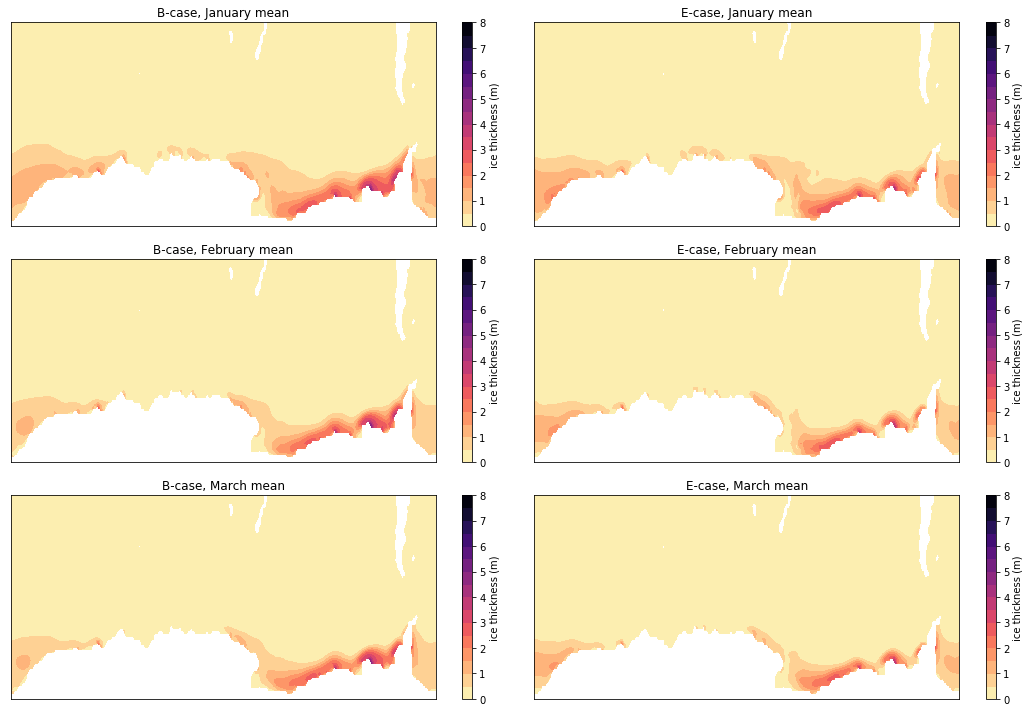

In [10]:
#Plot maps for mean J, F, M sea ice

f=plt.figure(figsize=(15,10))
gs=GridSpec(3,2)

month_str=['January','February','March']

levels=np.arange(0,8.1,0.5)
for mm in range(3): #loops through 0,1,2, which count from the 0th month (J), 1st month (F), and 2nd month (M)
    plt.subplot(gs[mm,0])
    cs=plt.contourf(hi_b_monthly[mm],levels,cmap=plt.cm.magma_r)
    plt.xticks([],[])
    plt.yticks([],[])
    cb=plt.colorbar(cs)
    plt.title('B-case, '+month_str[mm]+' mean')
    cb.set_label('ice thickness (m)')
    
    plt.subplot(gs[mm,1])
    cs=plt.contourf(hi_e_monthly[mm],levels,cmap=plt.cm.magma_r)
    plt.xticks([],[])
    plt.yticks([],[])
    cb=plt.colorbar(cs)
    cb.set_label('ice thickness (m)')
    plt.title('E-case, '+month_str[mm]+' mean')
plt.tight_layout()

To more clearly see what's changed, let's take the difference of fully coupled minus SOM:

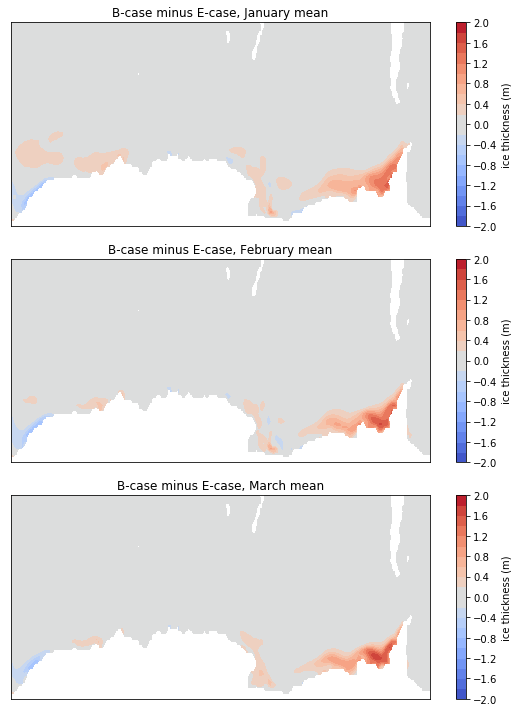

In [11]:
#Plot maps for mean J, F, M sea ice difference

f=plt.figure(figsize=(15,10))
gs=GridSpec(3,2)

month_str=['January','February','March']

maxlev=2
deltlev=maxlev/10
levels=np.concatenate((np.arange(-1*maxlev,0,deltlev),np.arange(deltlev,maxlev+deltlev/10,deltlev)))
for mm in range(3): #loops through 0,1,2, which count from the 0th month (J), 1st month (F), and 2nd month (M)
    plt.subplot(gs[mm,0])
    cs=plt.contourf(hi_b_monthly[mm]-hi_e_monthly[mm],levels,cmap=plt.cm.coolwarm)
    plt.xticks([],[])
    plt.yticks([],[])
    cb=plt.colorbar(cs,spacing='proportional',ticks=np.arange(-1*maxlev,maxlev+deltlev,deltlev*2))
    plt.title('B-case minus E-case, '+month_str[mm]+' mean')
    cb.set_label('ice thickness (m)')
    
plt.tight_layout()



**Group discussion question:** What's different about ice thickness in the two cases?  Are the monthly differences the same as for the annual mean?

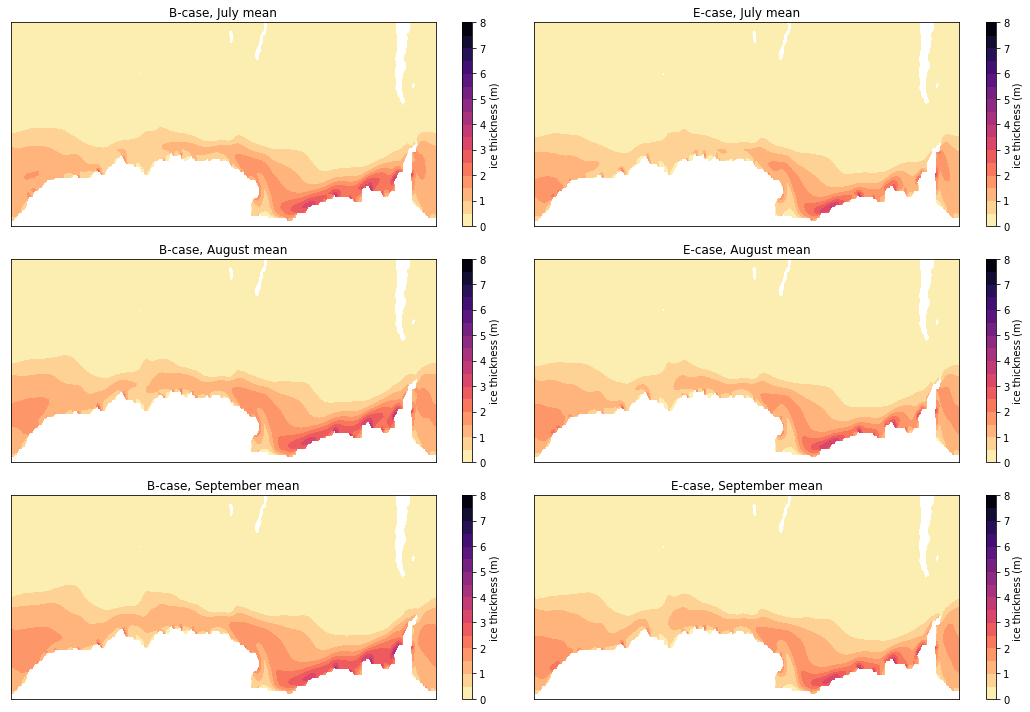

In [12]:
#Plot maps for mean J, A, S sea ice

f=plt.figure(figsize=(15,10))
gs=GridSpec(3,2)

month_str=['July','August','September']

levels=np.arange(0,8.1,0.5)
for mm in range(3):
    plt.subplot(gs[mm,0])
    cs=plt.contourf(hi_b_monthly[mm+6],levels,cmap=plt.cm.magma_r)
    plt.xticks([],[])
    plt.yticks([],[])
    cb=plt.colorbar(cs)
    plt.title('B-case, '+month_str[mm]+' mean')
    cb.set_label('ice thickness (m)')
    
    
    plt.subplot(gs[mm,1])
    cs=plt.contourf(hi_e_monthly[mm+6],levels,cmap=plt.cm.magma_r)
    plt.xticks([],[])
    plt.yticks([],[])
    cb=plt.colorbar(cs)
    cb.set_label('ice thickness (m)')
    plt.title('E-case, '+month_str[mm]+' mean')
plt.tight_layout()

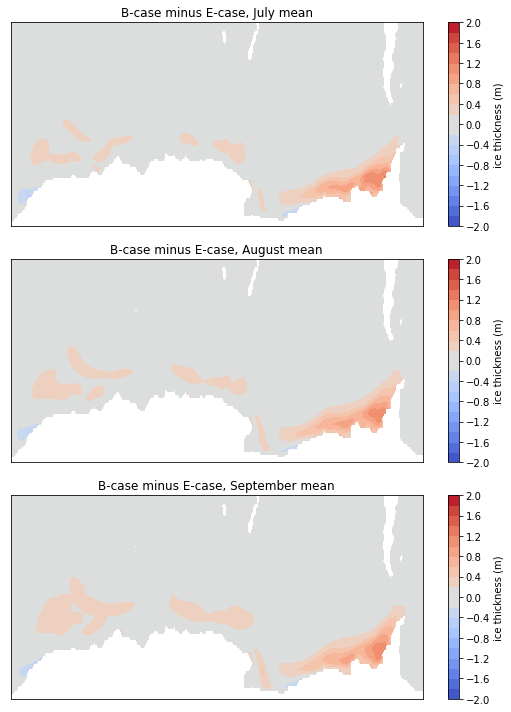

In [13]:
#Plot maps for mean J,A,S sea ice differences

f=plt.figure(figsize=(7.5,10))
gs=GridSpec(3,1)

month_str=['July','August','September']

maxlev=2
deltlev=maxlev/10
levels=np.concatenate((np.arange(-1*maxlev,0,deltlev),np.arange(deltlev,maxlev+deltlev/10,deltlev)))
for mm in range(3): #loops through 0,1,2, which count from the 0th month (J), 1st month (F), and 2nd month (M)
    plt.subplot(gs[mm,0])
    cs=plt.contourf(hi_b_monthly[mm+6]-hi_e_monthly[mm+6],levels,cmap=plt.cm.coolwarm)
    plt.xticks([],[])
    plt.yticks([],[])
    cb=plt.colorbar(cs,spacing='proportional',ticks=np.arange(-1*maxlev,maxlev+deltlev,deltlev*2))
    plt.title('B-case minus E-case, '+month_str[mm]+' mean')
    cb.set_label('ice thickness (m)')
    
plt.tight_layout()



#### Group discussion questions

Do you see any differences in ice thickness climatology in either the summer (JAS for NH, JFM for SH) or winter (JFM for NH, JAS for SH)?  Or are the differences the same year-round? 

Ok, it's your turn to practice plotting with Python.  In the cell below, you're going to make a few small changes to plot the difference all 12 calendar months.  There are ALL CAPS comments at the places where you need to make changes.

There are only 3 small places where the code needs to be changed, but feel free to also play with the contour levels and the colormap as well. 

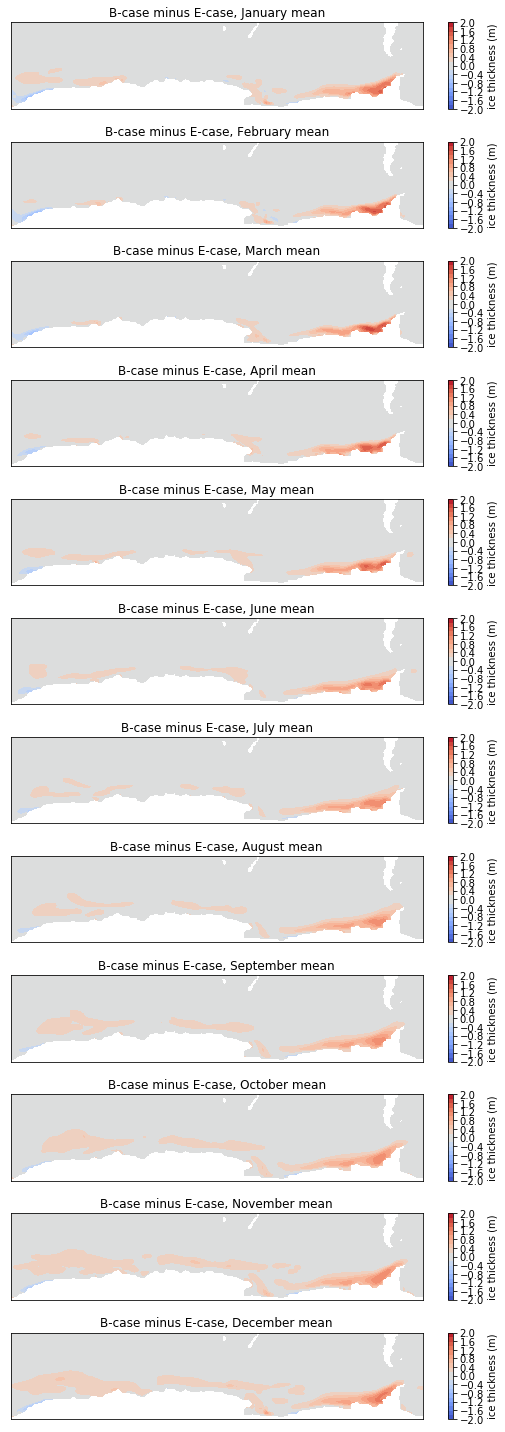

In [14]:
#Plot maps for mean J,A,S sea ice differences

f=plt.figure(figsize=(7.5,20))  ##NEED TO MAKE THE HEIGHT OF THE WHOLE FIGURE LARGER. Pick a number like 20.
gs=GridSpec(12,1)          ##NEED 12 ROWS HERE!

month_str=['January',\
           'February',\
           'March',\
           'April',\
           'May',\
           'June',\
           'July',\
           'August',\
           'September',\
           'October',\
           'November',\
           'December']


##CHANGE UP THE CONTOUR INTERVALS SOMEHOW
maxlev=2
deltlev=maxlev/10
levels=np.concatenate((np.arange(-1*maxlev,0,deltlev),np.arange(deltlev,maxlev+deltlev/10,deltlev)))

for mm in range(12): #HERE! PUT IN NUMBER OF MONTHS IN CALENDAR YEAR. WANT TO LOOP THROUGH ALL MONTHS
    plt.subplot(gs[mm,0])
    cs=plt.contourf(hi_b_monthly[mm]-hi_e_monthly[mm],levels,cmap=plt.cm.coolwarm)
    ##FEEL FREE TO CHOOSE A DIFFERENT COLORMAP HERE: https://matplotlib.org/examples/color/colormaps_reference.html
    
    plt.xticks([],[])
    plt.yticks([],[])
    cb=plt.colorbar(cs,spacing='proportional',ticks=np.arange(-1*maxlev,maxlev+deltlev,deltlev*2))
    plt.title('B-case minus E-case, '+month_str[mm]+' mean')
    cb.set_label('ice thickness (m)')
    
plt.tight_layout()



### Patterns of sea ice thickness variability

In this next section, we are going to calculate Empirical Orthogonal Functions (EOF - also known as Principal Component Analysis or PCA) to see what the primary spatial modes of sea ice thickness variability are.  We will compare the patterns of variability in the fully coupled simulations to those with the slab ocean model to see how variability in sea ice thickness changes with and without a dynamic ocean. <br>

A couple of quick reminders about EOF analysis.  EOF/PCA analysis is a way to pick out to take a set of possibly correlated "observations" (for our example: each location's sea ice thickness time series is 1 observation) and then transforming these observations them into a set of variables that are uncorrelated (orthogonal to each other). Often in data science circles, EOF/PCA will be used for "dimensionality reduction," to transform data into a handful of constructed variables that explain most of the variability in the observations. <br>

In the geosciences, the classic use of EOFs is to take SST or SLP at every location in the Atlantic, Pacific, or Arctic, and construct what patterns of SST/SLP contain most of the variability. Most of the alphabet soup of modes of climate variability (ENSO, AMV, IPO, PDV, NAO...) are illustrated well by the first or second EOF of either SST or SLP in their respective locations. For more info, check out: https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/empirical-orthogonal-function-eof-analysis-and-rotated-eof-analysis <br>

Before we continue, a couple of quick definitions: <br>

- The EOFs are the spatial patterns
- The principal components (PC) are the time series that describe how much of each EOF are present at a given time
- By multiplying each EOF by its corresponding PC and then summing all N of these (e.g., $\sum_{i=1}^N EOF_i PC_i $), you can reconstruct the exact "observation" field at any given time.  Often, just a handful of EOFs/PCs, maybe ~10 or fewer, will reconstruct the field well enough without needing the rest of higher EOF/PCs. 

We are going to perform EOF analysis on the ice thickness and discover what patterns explain most of the ice thickness variability in the B versus E simulations.  First though, we need to process the model output a little bit.  We will remove the mean (use anomalies), area weight (so that each observation counts only as much as the area it takes up), turn the NaN's into zeros (b/c the routines choke on the NaNs), and reshape the 3d arrays (time x lat x lon) into 2d arrays (time x location). 

In [15]:
#Ok, now to prepare for EOF analysis

#1. take out time mean from each
hi_b_demean=hi_b-hi_b.mean('time')
hi_e_demean=hi_e-hi_e.mean('time')
print('de-meaned')

#2. weight by area of each grid box (so each "observation" only counts for as large as its grid area)
areat=ds_b['tarea'].isel(time=0)
hi_b_weighted=(hi_b_demean*areat).values
hi_e_weighted=(hi_e_demean*areat).values
print('area weighted')

#3. make all NaN's into zeros (PCA chokes on NaNs)  #THis will take a minute
hi_b_weighted[np.isnan(hi_b_weighted)]=0
hi_e_weighted[np.isnan(hi_e_weighted)]=0
print('NaN->0')

#4. reshape arrays so have dims of time x location
b_sh=np.shape(hi_b_weighted)
b_reshaped=hi_b_weighted.reshape(b_sh[0],np.prod(b_sh[1:]))

e_sh=np.shape(hi_e_weighted)
e_reshaped=hi_e_weighted.reshape(e_sh[0],np.prod(e_sh[1:]))
print('reshaped')


de-meaned
area weighted
NaN->0
reshaped


Our model outputs are processed.  In the next cell, the PCA analysis is done.  

*Side note: There are quite a few ways to do PCA in Python. Here we are using the PCA function from the scikit-learn package. The advantages of this implementation is that it's fast (b/c it allows you to specify a small number of EOFs rather than the full decomposition) and that this PCA routine uses the same syntax as in other sklearn routines for decomposition/dimensionality-reduction. This very similar syntax makes it easy to test out a lot of different machine learning techniques quickly.*

In [16]:
#Run PCA on each - going to keep only 10 EOFs
#THis will take a couple of seconds to complete

num_eofs=10

pca_b=PCA(n_components=num_eofs)
pca_b.fit(b_reshaped)
print('B done')

pca_e=PCA(n_components=num_eofs)
pca_e.fit(e_reshaped)
print('E done')


#What happens if you choose more than 10 EOFs?

B done
E done


First, we are going to look at how much variability (in terms of variance) each EOF explains:

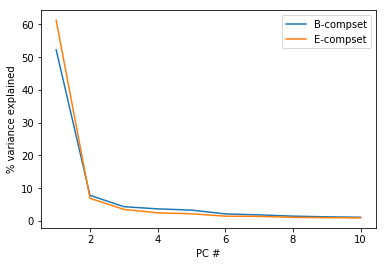

In [17]:
plt.plot(range(1,11),pca_b.explained_variance_ratio_*100,label='B-compset')
plt.plot(range(1,11),pca_e.explained_variance_ratio_*100,label='E-compset')

plt.ylabel('% variance explained')
plt.xlabel('PC #')
plt.legend()

#### Group discussion questions

- Are there any differences in the amount of variance explained by the first few EOFs from the B and E compsets?  
- How much variance is explained by the first EOF?  Any guesses what this EOF represents?

Next we will calculate the Principal Component time series to see what type of temporal behavior these EOFs have.

In [18]:
#pull out the principal component time series
#this will take about half a minute to run

t_ser_b=pca_b.fit_transform(b_reshaped)
t_ser_e=pca_e.fit_transform(e_reshaped)

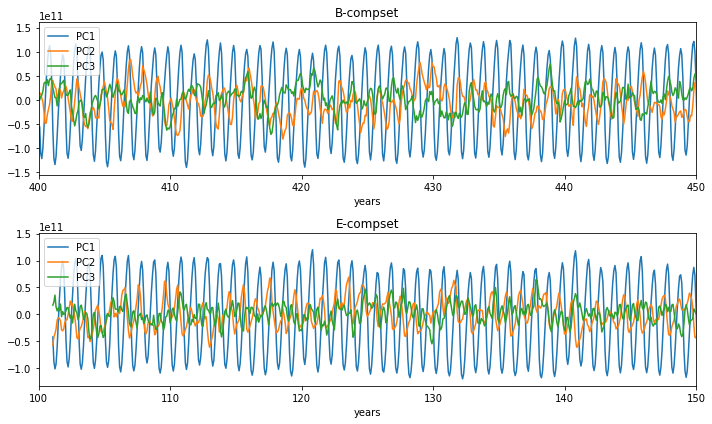

In [19]:
#plot the first three Principal Components for both the B and E compsets
f=plt.figure(figsize=(10,6))
gs=GridSpec(2,1)

neofs_toplot=3  #increase or decrease if you want to see more PCs

plt.subplot(gs[0,0])
[plt.plot(time_b/365,t_ser_b[:,ii],label='PC'+str(ii+1)) for ii in range(neofs_toplot)]  
plt.xlim([400,450])
plt.xlabel('years')
plt.legend()
plt.title('B-compset')

plt.subplot(gs[1,0])
[plt.plot(time_e/365,t_ser_e[:,ii],label='PC'+str(ii+1)) for ii in range(neofs_toplot)]
plt.xlim([100,150])
plt.title('E-compset')
plt.xlabel('years')
plt.legend()

plt.tight_layout()

#### Group Discussion Questions

- Now that you've seen what the time series look like, what is the first PC in both compsets?
- What kind of time scale behavior do you see in the 2rd and 3rd EOF?

If you want to see what the higher order PCs look like, feel free to go back and increase or decrease the number of PCs.

Next, we are going to plot the EOFs. To do this we need to reshape the EOFs back from 1d (locations) to 2d (lat x lon).  

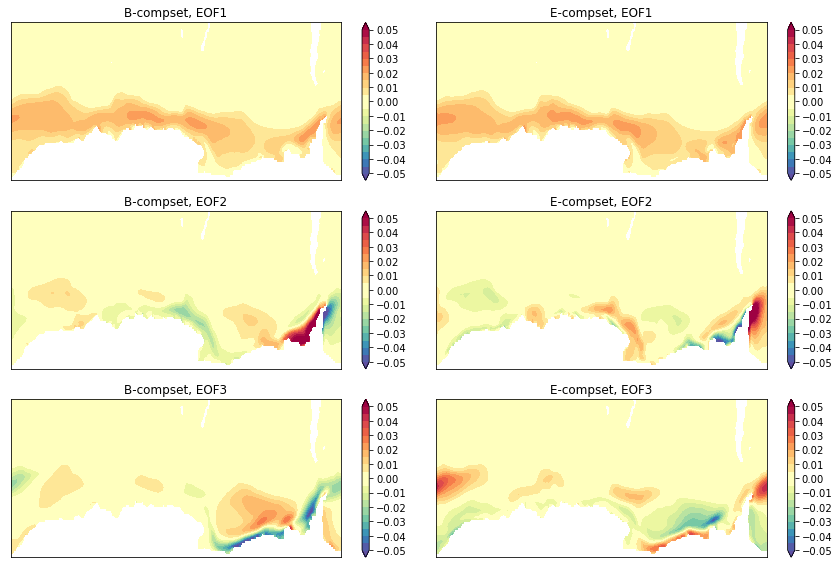

In [20]:
gs=GridSpec(3,2)
f=plt.figure(figsize=(12,8))


cmap=plt.cm.Spectral_r
maxlev=0.05
deltlev=maxlev/10
levels=np.concatenate((np.arange(-1*maxlev,0,deltlev),np.arange(deltlev,maxlev+deltlev/10,deltlev)))
for ii in range(3):
    fig=plt.subplot(gs[ii,0])
    plotthis=pca_b.components_[ii,:].reshape(b_sh[1],b_sh[2])  #here is where we reshape the EOF back to lat x lon
    plotthis=np.ma.array(plotthis, mask=np.isnan(hi_b_demean[0,:,:]))
    
    CS2=plt.contourf(plotthis,levels,cmap=cmap,extend='both')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title('B-compset, EOF'+str(ii+1))
    plt.colorbar(ticks=np.arange(-1*maxlev,maxlev+deltlev,deltlev*2),spacing='proportional')
    
    fig=plt.subplot(gs[ii,1])
    plotthis=pca_e.components_[ii,:].reshape(e_sh[1],e_sh[2])
    plotthis=np.ma.array(plotthis, mask=np.isnan(hi_e_demean[0,:,:]))
    CS2=plt.contourf(plotthis,levels,cmap=cmap,extend='both')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title('E-compset, EOF'+str(ii+1))
    plt.colorbar(ticks=np.arange(-1*maxlev,maxlev+deltlev,deltlev*2),spacing='proportional')
plt.tight_layout()

**Group discussion question:** Where is there ice thickening/thinning occurring with the seasonal cycle? <br>

Note: the PCA routine randomly decides which sign the EOFs have, so the EOF 1 from B and EOF1 from E have different signs but the same pattern. The PC1 from B and PC1 from E also have opposite signs. As a result, you'll get the same "observation" pattern if you reconstruct it at any given time. Despite the differing sign, these two EOF 1's represent the same process.

For example, if you were to reconstruct Hudson Bay thickness in a July in the B simulation, you'd be multiplying a positive number (from the EOF) against a negative number (from the PC) to show that low sea ice thickness in the summer.  For July in the Hudson Bay of the E simulation, you'd multiply a negative number (from the EOF) against a positive number (from the PC) to gain the same result that sea ice thickness is anomalously low in July.  


Ok, the seasonal cycle can be interesting, but let's take out the seasonal cycle to examine interannual and longer variability.  We are going to repeat the exact same analysis as above.  Nothing new here.

In [21]:
#Let's do the whole thing again, but this time de-seasonalize

#1. To take advantage of xarray dimension tracking, let's do the area weighting first this time
areat=ds_b['tarea'].isel(time=0)
hi_b_weighted=(hi_b*areat).values
hi_e_weighted=(hi_e*areat).values
print('area weighted')

#2. take out time month mean from each
hi_b_deseason=np.empty(np.shape(hi_b))
hi_e_deseason=np.empty(np.shape(hi_e))

print('deseasonalizing now')
for mm in range(12):
    print('month',mm)
    hi_b_deseason[mm::12,:,:]=hi_b_weighted[mm::12,:,:]-hi_b_weighted[mm::12,:,:].mean(axis=0)[None,:,:]
    hi_e_deseason[mm::12,:,:]=hi_e_weighted[mm::12,:,:]-hi_e_weighted[mm::12,:,:].mean(axis=0)[None,:,:]
print('de-meaned')


#3. make all NaN's into zeros (PCA chokes on NaNs)  #THis will take a minute
hi_b_deseason[np.isnan(hi_b_deseason)]=0
hi_e_deseason[np.isnan(hi_e_deseason)]=0
print('NaN->0')

#4. reshape arrays so have dims of time x location
b_sh=np.shape(hi_b_deseason)
b_reshaped_des=hi_b_deseason.reshape(b_sh[0],np.prod(b_sh[1:]))

e_sh=np.shape(hi_e_deseason)
e_reshaped_des=hi_e_deseason.reshape(e_sh[0],np.prod(e_sh[1:]))
print('reshaped')


area weighted
deseasonalizing now
month 0
month 1
month 2
month 3
month 4
month 5
month 6
month 7
month 8
month 9
month 10
month 11
de-meaned
NaN->0
reshaped


In [22]:
#Run PCA on each - going to keep only 10 modes

num_eofs=10

pca_b_des=PCA(n_components=num_eofs)
pca_b_des.fit(b_reshaped_des)
print('B done')

pca_e_des=PCA(n_components=num_eofs)
pca_e_des.fit(e_reshaped_des)
print('E done')


B done
E done


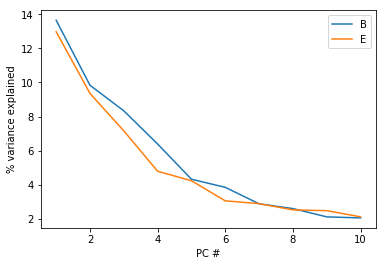

In [23]:
plt.plot(range(1,11),pca_b_des.explained_variance_ratio_*100,label='B')
plt.plot(range(1,11),pca_e_des.explained_variance_ratio_*100,label='E')

plt.ylabel('% variance explained')
plt.xlabel('PC #')
plt.legend()



**Group discussion question:** What's different about the amount of variance explained by the first few PCs in the deseasonalized model output as compared to the raw output?

In [24]:
#pull out the principal component time series

t_ser_b_des=pca_b_des.fit_transform(b_reshaped_des)
t_ser_e_des=pca_e_des.fit_transform(e_reshaped_des)

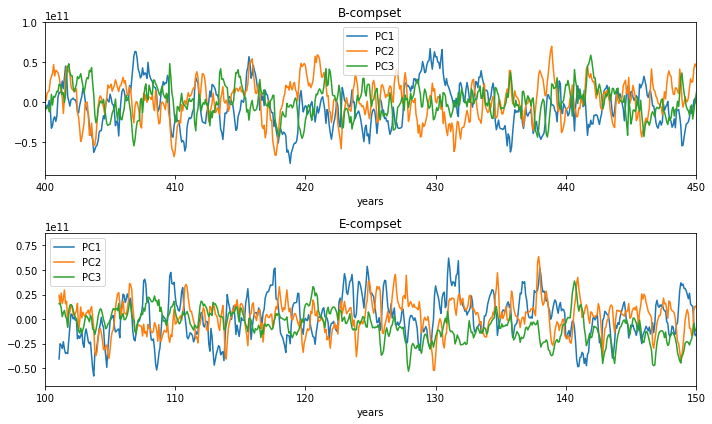

In [25]:
#plot
f=plt.figure(figsize=(10,6))
gs=GridSpec(2,1)

plt.subplot(gs[0,0])
[plt.plot(time_b/365,t_ser_b_des[:,ii],label='PC'+str(ii+1)) for ii in range(3)]
plt.xlim([400,450])
plt.xlabel('years')
plt.legend()
plt.title('B-compset')

plt.subplot(gs[1,0])
[plt.plot(time_e/365,t_ser_e_des[:,ii],label='PC'+str(ii+1)) for ii in range(3)]
plt.xlim([100,150])
plt.title('E-compset')
plt.xlabel('years')
plt.legend()

plt.tight_layout()

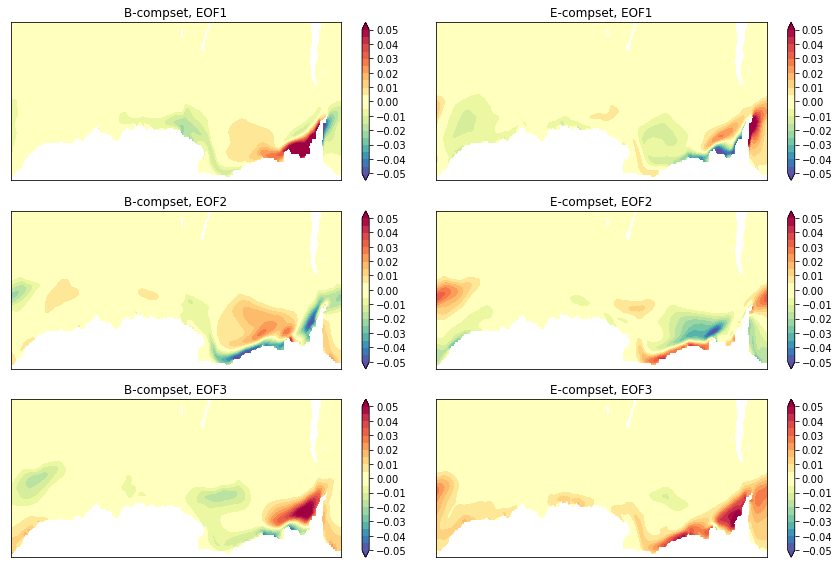

In [29]:
gs=GridSpec(3,2)
f=plt.figure(figsize=(12,8))

maxlev=0.05
deltlev=maxlev/10
cmap=plt.cm.Spectral_r
for ii in range(3):
    fig=plt.subplot(gs[ii,0])
    levels=np.concatenate((np.arange(-1*maxlev,0,deltlev),np.arange(deltlev,maxlev+deltlev/10,deltlev)))
    plotthis=pca_b_des.components_[ii,:].reshape(b_sh[1],b_sh[2])
    plotthis=np.ma.array(plotthis, mask=np.isnan(hi_b_demean[0,:,:]))
    
    CS2=plt.contourf(plotthis,levels,cmap=cmap,extend='both')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title('B-compset, EOF'+str(ii+1))
    plt.colorbar(ticks=np.arange(-1*maxlev,maxlev+deltlev,deltlev*2),spacing='proportional')
    
    fig=plt.subplot(gs[ii,1])
    plotthis=pca_e_des.components_[ii,:].reshape(e_sh[1],e_sh[2])
    plotthis=np.ma.array(plotthis, mask=np.isnan(hi_e_demean[0,:,:]))
    CS2=plt.contourf(plotthis,levels,cmap=cmap,extend='both')
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title('E-compset, EOF'+str(ii+1))
    plt.colorbar(ticks=np.arange(-1*maxlev,maxlev+deltlev,deltlev*2),spacing='proportional')
plt.tight_layout()

#### Group Discussion Questions

- What's different about the PCs and EOFs now that we've taken out the seasonal cycle?
- Are any of the EOF patterns of sea ice thickness similar in the B and E compset cases?  Are any of them different?
- What processes might be leading to similar/different modes of variability in sea ice thickness when a dynamic ocean is included?

Try going back and plotting more PC time series and EOFs. At what point do the patterns start to look like they aren't physically meaningful (e.g., like noise)? <br>

If you finished this activity well before lunch, clear this notebook and start again with the other pole. To clear the output of the notebook, in the menu above, click "Kernel," then select "Restart & Clear Output."  Scroll back to the top and wait 10 seconds for the notebook's kernel to restart.

### A couple of final things to think about
- What other diagnostic variables might you examine to determine what causes the differences/similarities in the seasonal cycle and patterns of variability in the B versus E compset?  
- What can you learn from including or excluding the influence of ocean dynamics? In this case? In your own research (if applicable...) 
